<a href="https://colab.research.google.com/github/smerinobluewin/hello-world/blob/master/brown_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

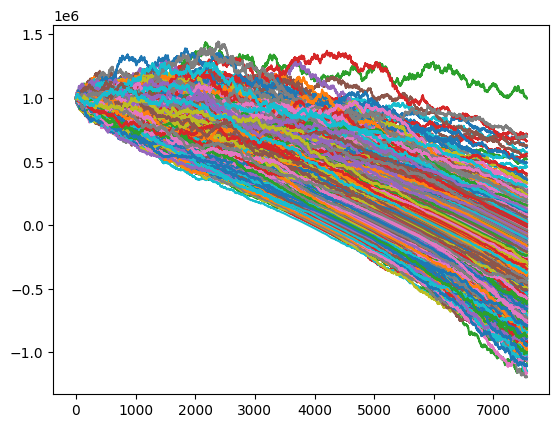

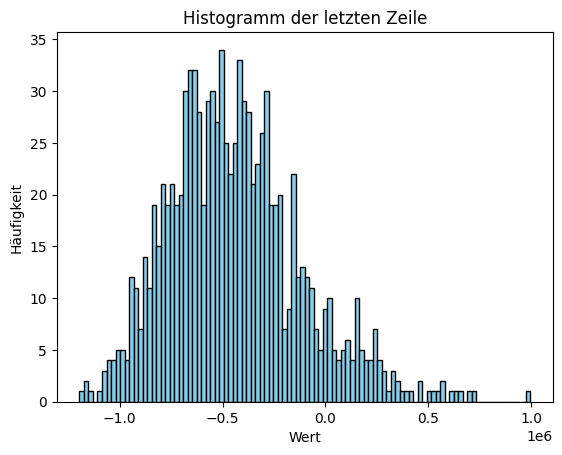

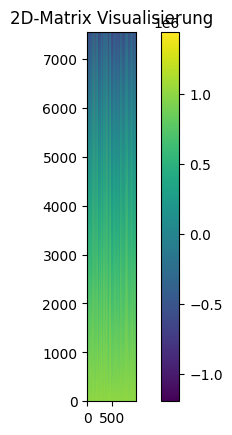

-1197640.0
1444582.0


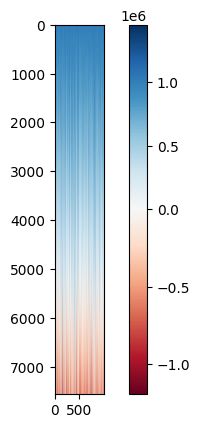

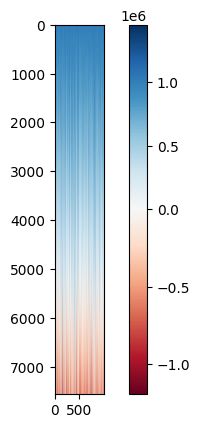

In [ ]:
from PIL.Image import SupportsArrayInterface
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors






mu=0.03
sigma=0.05
Sstart=1000000
S1=Sstart
C=60000
Npath=1000                   # number of simulation paths
N= 30*252                    # number of time steps (days)
dt=1/252                      # 252 trading days
S1=S1*np.ones((1, Npath))  # initialize row vector of length Npath to build matrix of paths
S1=np.round(S1,0)
#print(S1)
DATA=-1*np.ones((N,Npath))    # initialize matrix of paths with Npath scenarios of time length N
#print(DATA)
# St=np.array([S1], dtype=np.float32)

DATA[0, :] = S1
#print(f"{DATA=}")

for number in range(1,N):
  #print(number)
  rng=np.random.default_rng()
  eps=rng.standard_normal((1, Npath)) # Note the tuple for dimensions
  #print(eps)
  #eps=random.normalvariate(mu=0,sigma=1)
  S=S1+S1*(mu*dt+sigma*eps*np.sqrt(dt)) - C*dt
  #print(S)
  DATA[number, :] = S
  S1=S
  #St=np.column_stack((St,S))

DATA=np.round(DATA,0)
#print(DATA)
#print(f"{DATA=}")
#print(St[1:10])
#print(St[-1])

data=DATA.flatten()
#print(data[1:11])

# Analogous to plot(x) in MATLAB
#plt.plot(DATA[:,1])
#plt.show()

plt.plot(DATA)
plt.show()

plt.hist(DATA[-1], bins=100, color='skyblue', edgecolor='black')
plt.title("Histogramm der letzten Zeile")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

plt.imshow(DATA, cmap='viridis', origin='lower') # 'cmap' definiert das Farbschema
plt.colorbar() # Fügt die Farbskala an der Seite hinzu
plt.title("2D-Matrix Visualisierung")
plt.show()





# Beispiel: Werte von -50 bis +100
#data = np.random.uniform(-50, 100, (10, 10))

# Normierung: - SStart ist das Minimum, 0 ist die Mitte (Weiss), Sstart ist das Maximum
minDATA = DATA.min()
maxDATA = DATA.max()

print(f"{minDATA}")
print(f"{maxDATA}")

norm = colors.TwoSlopeNorm(vmin=minDATA, vcenter=0, vmax=maxDATA)
plt.imshow(DATA, cmap='RdBu', norm=norm)
plt.colorbar()
plt.show()

plt.imshow(DATA, cmap='RdBu', norm=norm)
plt.colorbar()
plt.show()



#sns.heatmap(DATA, annot=True, cmap='YlGnBu')
#plt.show()

#plt.hist(data, bins=100, color='skyblue', edgecolor='black')
#plt.title("Mein erstes Histogramm")
#plt.xlabel("Werte")
#plt.ylabel("Häufigkeit")
#plt.show()

